# Performance of MLP Diffusion Model in Gaussian Mixture Data  

Li Yuhao  
March 17, 2024  
updated on March 20, 2024  

This is a jupyter notebook about the diffusion model, which uses MLP to fit the noise in the reverse process. The data set used is Gaussian mixture data with two centers. The final code in the notebook draws a nice 3D diagram showing the process from Gaussian mixture data through diffusion to Gaussian distribution and then back to Gaussian mixture data through denoising.

An early version of the code was completed on March 17 and presented at PMI group meeting that day. On March 20, I simplified and corrected the code, optimized the readability of the code, and wrote a corresponding technical document.


In [1]:
import os
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

os.makedirs('results', exist_ok=True)
sns.set(style="white", color_codes=True)

## 1. Define Data and Model  

In [2]:
def get_Gaussian_mixture_data(each_nums, A_mean, A_std, B_mean, B_std):
    num = torch.Size([each_nums])
    A_mean_vector = torch.tensor([A_mean, A_mean])
    A_std_vector = torch.tensor([A_std, A_std])
    B_mean_vector = torch.tensor([B_mean, B_mean])
    B_std_vector = torch.tensor([B_std, B_std])

    A_dist = torch.distributions.Normal(A_mean_vector, A_std_vector)
    A_samp = A_dist.sample(num)

    B_dist = torch.distributions.Normal(B_mean_vector, B_std_vector)
    B_samp = B_dist.sample(num)

    Gaussian_mixture_data = torch.cat([A_samp, B_samp], dim=0)

    return Gaussian_mixture_data

class MLPDiffusion(nn.Module):
    def __init__(self, steps, hidden_size):
        super(MLPDiffusion, self).__init__()
        
        self.Linear_layer_1 = nn.Linear(2, hidden_size)
        self.Linear_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.Linear_layer_3 = nn.Linear(hidden_size, 2)
        
        self.Embedding_layer_1 = nn.Embedding(steps, hidden_size)
        self.Embedding_layer_2 = nn.Embedding(steps, hidden_size)
        
    def forward(self, z0, t):
        h1 = self.Linear_layer_1(z0) + self.Embedding_layer_1(t)
        z1 = torch.relu(h1)
        h2 = self.Linear_layer_2(z1) + self.Embedding_layer_2(t)
        z2 = torch.relu(h2)
        prediction = self.Linear_layer_3(z2)
        
        return prediction
    
    def loss_fun(self, x_last, steps, alpha_prod):
        batch_size = x_last.shape[0]
        
        half_t = torch.randint(0, steps, size=(batch_size // 2,))
        random_t = torch.cat([half_t, steps - 1 - half_t], dim=0).unsqueeze(-1)
        
        noise = torch.randn_like(x_last)
        a = torch.sqrt(alpha_prod[random_t])
        b = torch.sqrt(1 - alpha_prod[random_t])
        
        x = a * x_last + b * noise
        
        predicted_noise = self.forward(x, random_t.squeeze(-1))
        
        return (noise - predicted_noise).square().mean()
    
    def sampling(self, x, steps, alpha_prod):
        alpha = alpha_prod[0]
        beta = 1 - alpha
        predicted_x_t_list = [x]
        cur_x = x
        for t in reversed(range(steps)):
            predicted_noise = self.forward(cur_x, torch.tensor([t]))
            mean = (cur_x - beta * predicted_noise / np.sqrt(1 - alpha_prod[t])) / np.sqrt(alpha)
            sigma = np.sqrt(beta * (1 - alpha_prod[t] / alpha) / (1 - alpha_prod[t]))
            cur_x = mean + sigma * torch.randn_like(x)
            
            predicted_x_t_list.append(cur_x.detach())
            
        return predicted_x_t_list

## 2. Train Model and Plot Intermediate Results

In [3]:
# Parameters of data generation
each_points = 500
A_mean = -1.25
A_std = 0.25
B_mean = 1.25
B_std = 0.25

# Parameters of diffusion process
diffused_steps = 300
alpha = 0.99

# Parameters of model
hidden_size = 128
batch_size = 128
epoch_num = 1000
lr = 0.006

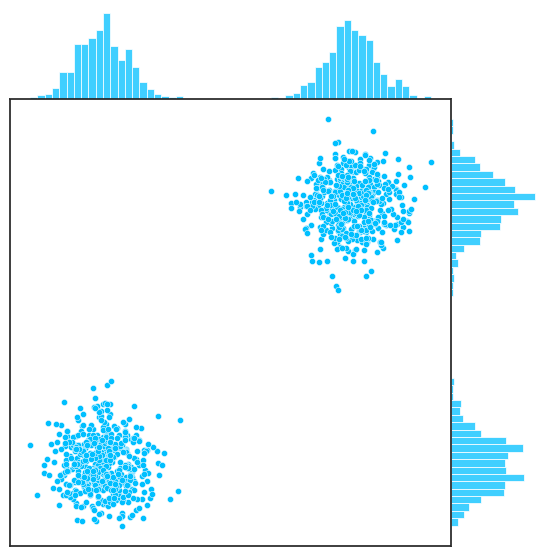

In [4]:
# Generate data

x_0 = get_Gaussian_mixture_data(each_points, A_mean, A_std, B_mean, B_std)

# Plot 
sns.jointplot(x=x_0[:,0], y=x_0[:,1], color='deepskyblue', space=0, 
              marginal_ticks=False, marginal_kws=dict(bins=55), marker="o", s=20)
plt.xticks([])
plt.yticks([])
plt.savefig('results/Gaussian_mixture_data.pdf')
plt.show()

In [5]:
# Diffusion process

diffused_x_t_list = [x_0]
for t in tqdm(range(diffused_steps)):
    noise = torch.randn_like(x_0)
    x_t = np.sqrt(alpha) * diffused_x_t_list[t] + np.sqrt(1-alpha) * noise
    diffused_x_t_list.append(x_t)

100%|██████████| 300/300 [00:00<00:00, 17623.62it/s]


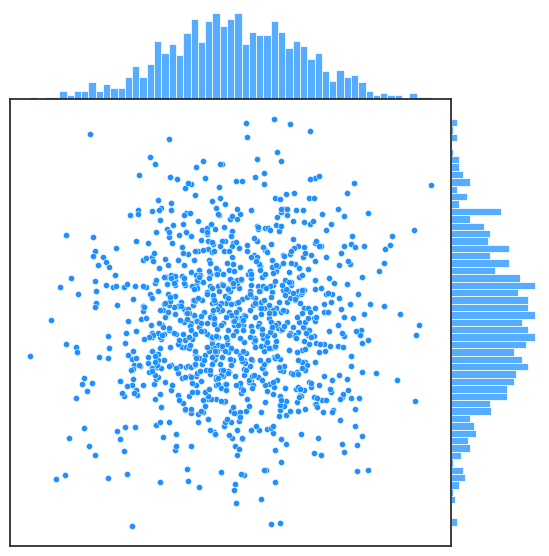

In [6]:
# Plot the data distribution after diffusion

diffused_result = diffused_x_t_list[-1]

sns.jointplot(x=diffused_result[:,0], y=diffused_result[:,1], color='dodgerblue', 
              space=0, marginal_ticks=False, marginal_kws=dict(bins=55), marker="o", s=20)
plt.xticks([])
plt.yticks([])
plt.savefig('results/diffused_result.pdf')
plt.show()

In [7]:
# Instantiate the model, optimizer, and load the data set

diffusion_model = MLPDiffusion(diffused_steps, hidden_size)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(x_0, batch_size, shuffle=True)

# Calculate the cumulative product of alpha

alpha_prod = torch.cumprod(torch.full((diffused_steps, ), alpha), dim=0)

# Train the model
for t in tqdm(range(epoch_num)):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_model.loss_fun(batch_x, diffused_steps, alpha_prod)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.)
        optimizer.step()

100%|██████████| 1000/1000 [01:29<00:00, 11.17it/s]


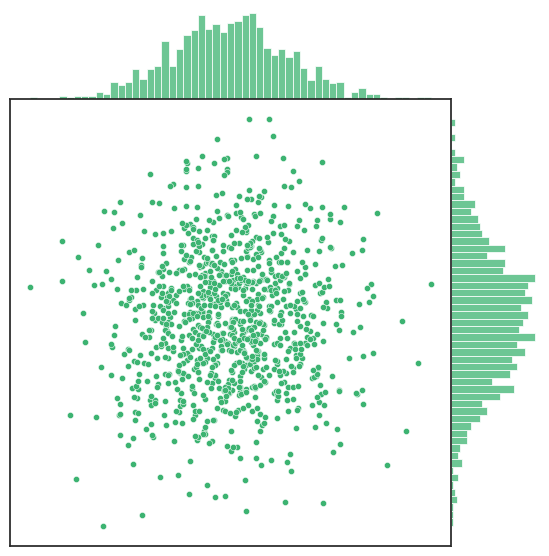

In [8]:
# Resampling from a Gaussian distribution

resampled_x_0 = torch.randn_like(x_0)

sns.jointplot(x=resampled_x_0[:,0], y=resampled_x_0[:,1], color='mediumseagreen', 
              space=0, marginal_ticks=False, marginal_kws=dict(bins=55), marker="o", s=20)
plt.xticks([])
plt.yticks([])
plt.savefig('results/resampling_x_0.pdf')
plt.show()

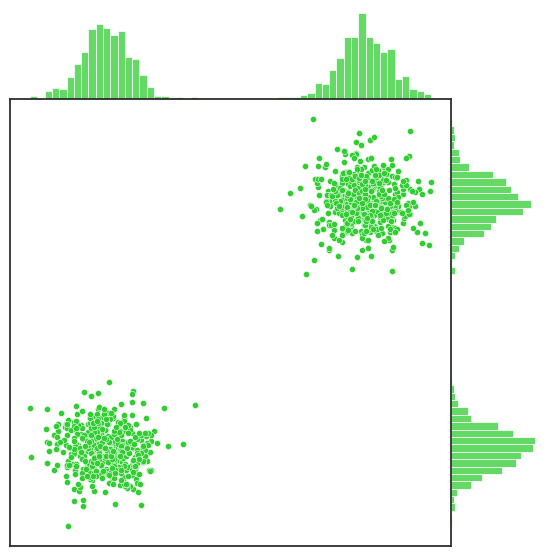

In [9]:
# Return to the Gaussian mixture distribution through the trained model

reversed_x_t_list = diffusion_model.sampling(resampled_x_0, diffused_steps, alpha_prod)
reversed_result = reversed_x_t_list[-1]

sns.jointplot(x=reversed_result[:,0], y=reversed_result[:,1], color='limegreen', 
              space=0, marginal_ticks=False, marginal_kws=dict(bins=55), marker="o", s=20)
plt.xticks([])
plt.yticks([])
plt.savefig('results/reversed_result.pdf')
plt.show()

In [10]:
diff_data = np.array([diffused_x_t_list[i].tolist() for i in range(diffused_steps)])
deno_data = np.array([reversed_x_t_list[i].detach().numpy() for i in range(diffused_steps)])

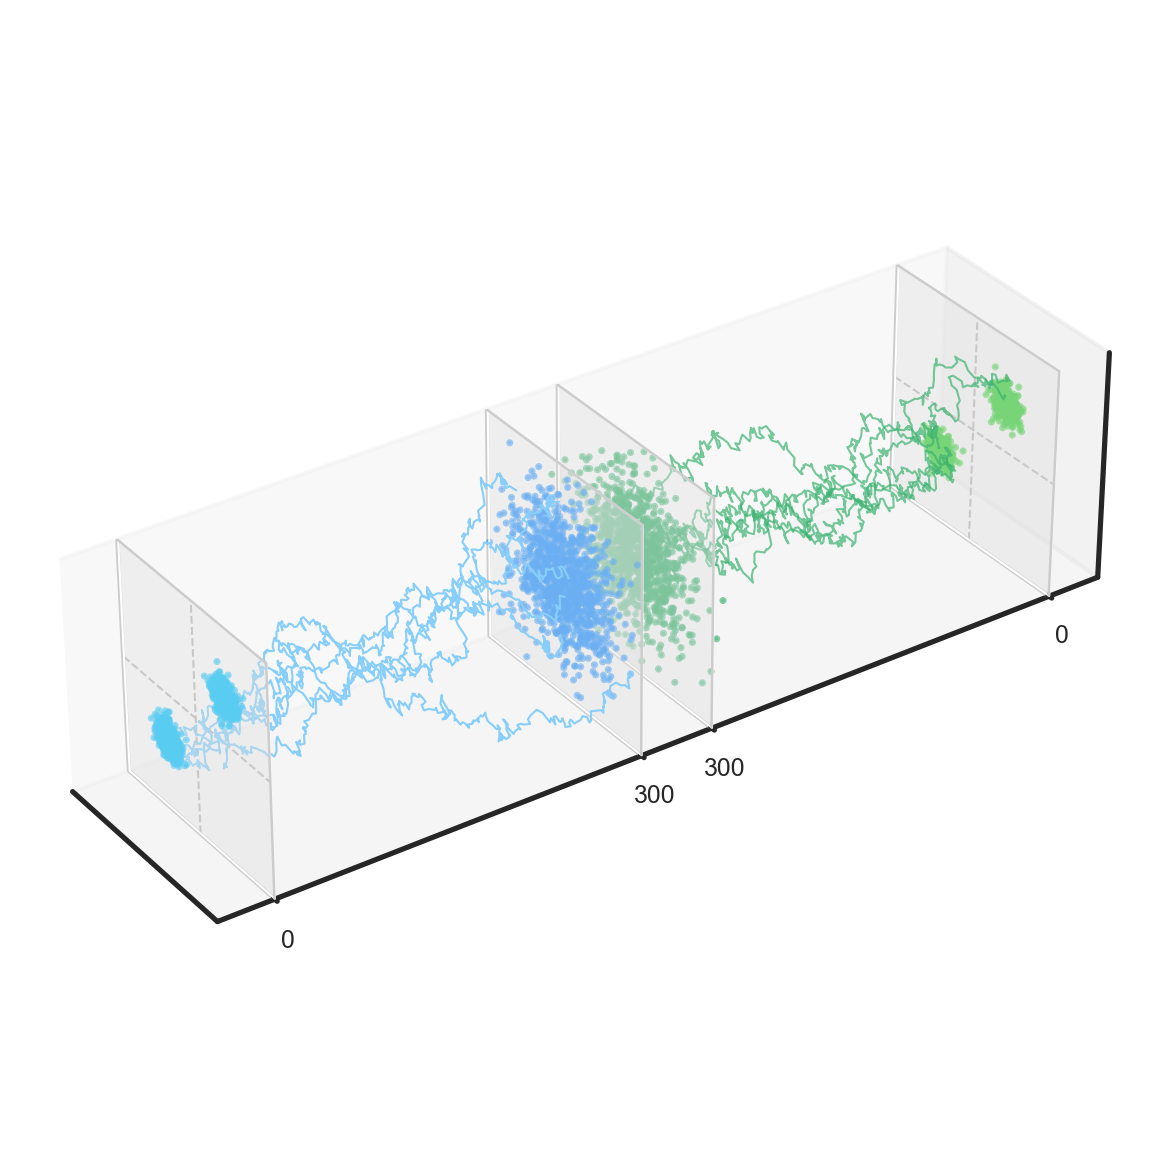

In [11]:
# Plot the 3D diagram

fig = plt.figure(dpi=300)
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(np.linspace(-3.11, 3.11, 2), np.linspace(-3.11, 3.11, 2))
ax.plot_surface(X, Y=0, Z=Y, color='#fefefe', alpha=0.4, linewidth=0.5, zorder=9)
ax.plot_surface(X, Y=1, Z=Y, color='#fefefe', alpha=0.4, linewidth=0.5, zorder=1)
ax.plot_surface(X, Y=1.2, Z=Y, color='#fefefe', alpha=0.4, linewidth=0.5, zorder=1)
ax.plot_surface(X, Y=2.2, Z=Y, color='#fefefe', alpha=0.4, linewidth=0.5, zorder=1)

original_data_x = x_0[:, 0]
original_data_y = np.zeros([each_points * 2])
original_data_z = x_0[:, 1]

diffused_data_x = diffused_result[:, 0]
diffused_data_y = np.zeros([each_points * 2]) + 1
diffused_data_z = diffused_result[:, 1]

resampled_data_x = resampled_x_0[:, 0]
resampled_data_y = np.zeros([each_points * 2]) + 1.2
resampled_data_z = resampled_x_0[:, 1]

reversed_data_x = reversed_result[:, 0]
reversed_data_y = np.zeros([each_points * 2]) + 2.2
reversed_data_z = reversed_result[:, 1]

ax.scatter(original_data_x, original_data_y, original_data_z, color='deepskyblue', s=0.5, alpha=0.6, zorder=9)
ax.scatter(diffused_data_x, diffused_data_y, diffused_data_z, color='dodgerblue', s=0.5, alpha=0.6, zorder=2)
ax.scatter(resampled_data_x, resampled_data_y, resampled_data_z, color='mediumseagreen', s=0.5, alpha=0.6, zorder=2)
ax.scatter(reversed_data_x, reversed_data_y, reversed_data_z, color='limegreen', s=0.5, alpha=0.6, zorder=2)

diff_id_1 = 123
diff_id_2 = 234
diff_id_3 = 345
diff_id_4 = 456
diff_id_5 = 567
diff_id_6 = 678

diff_y = np.linspace(0, 1, diffused_steps)

diff_1_x = diff_data[:, diff_id_1, 0]
diff_1_z = diff_data[:, diff_id_1, 1]

diff_2_x = diff_data[:, diff_id_2, 0]
diff_2_z = diff_data[:, diff_id_2, 1]

diff_3_x = diff_data[:, diff_id_3, 0]
diff_3_z = diff_data[:, diff_id_3, 1]

diff_4_x = diff_data[:, diff_id_4, 0]
diff_4_z = diff_data[:, diff_id_4, 1]

diff_5_x = diff_data[:, diff_id_5, 0]
diff_5_z = diff_data[:, diff_id_5, 1]

diff_6_x = diff_data[:, diff_id_6, 0]
deno_6_z = deno_data[:, diff_id_6, 1]

deno_id_1 = 123
deno_id_2 = 234
deno_id_3 = 345
deno_id_4 = 456
deno_id_5 = 567
deno_id_6 = 678

deno_y = np.linspace(1.2, 2.2, diffused_steps)

deno_1_x = deno_data[:, deno_id_1, 0]
deno_1_z = deno_data[:, deno_id_1, 1]

deno_2_x = deno_data[:, deno_id_2, 0]
deno_2_z = deno_data[:, deno_id_2, 1]

deno_3_x = deno_data[:, deno_id_3, 0]
deno_3_z = deno_data[:, deno_id_3, 1]

deno_4_x = deno_data[:, deno_id_4, 0]
deno_4_z = deno_data[:, deno_id_4, 1]

deno_5_x = deno_data[:, deno_id_5, 0]
deno_5_z = deno_data[:, deno_id_5, 1]

deno_6_x = deno_data[:, deno_id_6, 0]
deno_6_z = deno_data[:, deno_id_6, 1]

diff_color = 'lightskyblue'
ax.plot(diff_1_x, diff_y, diff_1_z, linewidth=0.5, zorder=7, color=diff_color)
ax.plot(diff_2_x, diff_y, diff_2_z, linewidth=0.5, zorder=7, color=diff_color)
ax.plot(diff_3_x, diff_y, diff_3_z, linewidth=0.5, zorder=7, color=diff_color)
ax.plot(diff_4_x, diff_y, diff_4_z, linewidth=0.5, zorder=7, color=diff_color)
ax.plot(diff_5_x, diff_y, diff_5_z, linewidth=0.5, zorder=7, color=diff_color)
ax.plot(diff_6_x, diff_y, deno_6_z, linewidth=0.5, zorder=7, color=diff_color)

deno_color = 'mediumseagreen'
ax.plot(deno_1_x, deno_y, deno_1_z, linewidth=0.5, alpha=0.7, zorder=3, color=deno_color)
ax.plot(deno_2_x, deno_y, deno_2_z, linewidth=0.5, alpha=0.7, zorder=3, color=deno_color)
ax.plot(deno_3_x, deno_y, deno_3_z, linewidth=0.5, alpha=0.7, zorder=3, color=deno_color)
ax.plot(deno_4_x, deno_y, deno_4_z, linewidth=0.5, alpha=0.7, zorder=3, color=deno_color)
ax.plot(deno_5_x, deno_y, deno_5_z, linewidth=0.5, alpha=0.7, zorder=3, color=deno_color)
ax.plot(deno_6_x, deno_y, deno_6_z, linewidth=0.5, alpha=0.7, zorder=3, color=deno_color)

ax.plot([-3.11,3.11],[0,0],[3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)
ax.plot([3.11,3.11],[0,0],[-3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)

ax.plot([-3.11,3.11],[1,1],[3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)
ax.plot([3.11,3.11],[1,1],[-3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)

ax.plot([-3.11,3.11],[1.2,1.2],[3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)
ax.plot([3.11,3.11],[1.2,1.2],[-3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)

ax.plot([-3.11,3.11],[2.2,2.2],[3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)
ax.plot([3.11,3.11],[2.2,2.2],[-3.11,3.11], color='#cccccc', linewidth=0.6, zorder=10)

ax.plot([-3.11,3.11],[0,0],[0,0], '--', color='#bbb8b8', linewidth=0.5)
ax.plot([0,0],[0,0],[-3.11,3.11], '--', color='#bbb8b8', linewidth=0.5)

ax.plot([-3.11,3.11],[2.2,2.2],[0,0], '--', color='#bbb8b8', linewidth=0.5)
ax.plot([0,0],[2.2,2.2],[-3.11,3.11], '--', color='#bbb8b8', linewidth=0.5)

ax.set(xlim=[-3, 3], ylim=[-0.1, 2.3], zlim=[-3, 3])
ax.set(xticks=[], zticks=[], yticks=[0, 1, 1.2, 2.2])
ax.set_yticklabels([0,300,300,0], fontsize=6)

ax.set_box_aspect([1, 4, 1])
ax.view_init(32, -35)
plt.savefig('results/total_process.pdf')
plt.show()